# Pulmonary Fibrosis - Predicting Progression from Baseline CT Scans and Patient Characteristics

## Final -  Best Model Runs

In [1]:
import os
import cv2
import pydicom
import pylibjpeg
import gdcm
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
import math
from tqdm.notebook import tqdm
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, MaxPooling2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
) 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.applications as tfa

from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping

from numpy import loadtxt
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import concatenate

from scipy import stats
import seaborn as sns

import datetime


def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [2]:
#Uncomment this code for training on a multi-GPU VM
#mirrored_strategy = tf.distribute.MirroredStrategy()

In [3]:
BATCH_SIZE = 8
SAVE_BEST = True
MODEL_CLASS = 'b5'
EPOCHS=30

# Preparing the data that will fit the models #
We have created a separated notebook for EDA of tabular data and images. Here we show the functions and classes that allow us to extract the data that will go into the models.

In [4]:
#read the tabular data from train.csv
df_import = pd.read_csv('./train.csv')


### Calculate output value (Least Squares Slope of FVC) for all patients


In [5]:
def create_output(df):

    #Create containers to store the data 
    target = pd.DataFrame(columns=['Patient', 'Slope']) # dataframe with target output 

    #Calculate slope for each patient in the train set
    for p in df.Patient.unique():
        #subsample the training set
        sub = df[df.Patient == p]
        #get the FVC for the p-patient
        fvc = sub.FVC.values
        #get the Weeks for the p-patient
        weeks = sub.Weeks.values

        #calculate the slope using linar regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

        #fill out dictionaries with corresponding data
        target = target.append({'Patient' : p, 'Slope' : slope}, ignore_index = True)
        
    return target

In [6]:
target = create_output(df_import)

### Scale the output variable

In [7]:
slope=target.Slope.values.copy()
slope = slope.reshape(-1, 1)
slope_scaler = MinMaxScaler()
scaled_slope = slope_scaler.fit_transform(slope)

### Process Input Dataframe to Generate Baseline Tabular Data for Each Patient

In [8]:
tabular = pd.DataFrame(columns =['Patient', 'FVC', 'Percent', 'Age', 'Sex', 'SS1', 'SS2'])

for p in df_import.Patient.unique():
    
    sub=df_import[df_import.Patient ==p]
    
    f = sub.FVC.values[0]
    pct = sub.Percent.values[0]
    a = sub.Age.values[0]
    s = sub.Sex.values[0]
    ss = sub.SmokingStatus.values[0]
    
    #encode the categorical variables
    
    if s == 'male':
        s_enc = 0
    else:
        s_enc = 1
    
    if ss == 'Never smoked':
        #encode as 0,0
        ss_1 = 0
        ss_2 = 0
    elif ss == 'Ex-smoker':
        #encode as 1, 1
        ss_1 = 1
        ss_2 = 1
    elif ss == 'Currently smokes':
        #encode as 0,1
        ss_1 = 0
        ss_2 = 1

    
    tabular = tabular.append({'Patient': p, 'FVC': f, 'Percent': pct, 'Age': a, 'Sex': s_enc, 'SS1': ss_1, 'SS2': ss_2}, ignore_index=True)

### Scale the tabular values

In [9]:

fvc = tabular.FVC.values.reshape(-1, 1)
pct = tabular.Percent.values.reshape(-1, 1)
age = tabular.Age.values.reshape(-1, 1)

fvc_scaler = MinMaxScaler()
pct_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()

fvc_scaled = fvc_scaler.fit_transform(fvc)
pct_scaled = pct_scaler.fit_transform(pct)
age_scaled = age_scaler.fit_transform(age)

sex = tabular.Sex.values.reshape(-1, 1)
ss1 = tabular.SS1.values.reshape(-1, 1)
ss2 = tabular.SS2.values.reshape(-1, 1)

### Recombine processed data back into Pandas before holdback

In [10]:

df_processed = pd.DataFrame()
df_processed['Patient'] = df_import.Patient.unique()
df_processed['Target'] = scaled_slope
df_processed['FVC']= fvc_scaled
df_processed['PCT'] = pct_scaled
df_processed['Age'] = age_scaled
df_processed['Sex'] = sex
df_processed['SS1'] = ss1
df_processed['SS2'] = ss2


### Make dictionaries for train test data selection

In [11]:
target={}
TAB = {}
for p in df_processed.Patient.unique():
    sub = df_processed[df_processed.Patient == p]
    target[p] = sub.Target.values[0]
    
    vector = [sub.FVC.values[0]]
    vector.append(sub.PCT.values[0])
    vector.append(sub.Age.values[0])
    vector.append(sub.Sex.values[0])
    vector.append(sub.SS1.values[0])
    vector.append(sub.SS2.values[0])
    vector = np.array(vector)
    
    TAB[p] = vector

### Select some patients to hold back to assess model performance

In [12]:
#get the full list of patient IDs
patient_ID = df_processed.Patient.unique()

In [13]:
#split the remaining patient IDs into train and test 
split = train_test_split(patient_ID, test_size=0.25, random_state=42)

(train_ID, test_ID) = split

### Image Processing

Process dicom images into format that CNN can use

In [14]:
#Function to process images
def get_img(path):
    """This function receives a path as an input,
    and outputs a resized CT scan image that was
    also transformed into Hounsfield units. The information 
    needed to transform the voxels is included in the
    metadata contained in each CT scan"""

    pd = pydicom.dcmread(path)
    r = cv2.resize((pd.pixel_array - pd.RescaleIntercept) / (pd.RescaleSlope * 1000), (512, 512))

    return r

Load the masked images (alternate approach)

In [15]:
def get_masked_img(path):
    """This function receives a path as an input,
    and outputs a resized CT scan image that was
    also transformed into Hounsfield units. The information 
    needed to transform the voxels is included in the
    metadata contained in each CT scan"""
    i = np.load(path)
    return i

Sample images for each patient and create tables of images combined with target output and tabular data (can be used to sample n_images for each patient or train on all available images)

In [16]:
class image_data(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in df_import.Patient.unique():
            self.train_data[p] = os.listdir(f'train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x], a

In [17]:
class masked_image_data(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in df_import.Patient.unique():
            self.train_data[p] = os.listdir(f'train_masked/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_masked_img(f'train_masked/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x], a

In [18]:
class tab_data(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in df_import.Patient.unique():
            self.train_data[p] = os.listdir(f'train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [tab], a

In [19]:
class combined_data(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in df_import.Patient.unique():
            self.train_data[p] = os.listdir(f'train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab], a

## Model Result Evaluation Functions

### Predict the slope for patient based on mean of that patient's scans (n_images) - more useful for inference on a given patient

In [20]:
def compare_slope_per_pt(model_input, data_type, df_input = df_import, patient_IDs=test_ID, image_type = 'unmasked', target=target, TAB=TAB, slope_scaler=slope_scaler, n_images=24):
    '''
    df_input: held back data frame of patients from original sample
    model_input: name of trained model for inference
    data_type: type of data for prediction - either 'image' for CNN, 'text' for MLP, or 'combined' for combined
    '''
    q = 0.5

    slopes = pd.DataFrame(columns=['Patient', 'Calculated_Slope', 'Lower_CI', 'Upper_CI', 'Predicted_Slope', 'Within_Range'])
    
    if image_type == 'unmasked':
        img_dir = 'train'
    if image_type == 'masked':
        img_dir = 'train_masked'
        
    
    df_data={}
    
    for p in patient_IDs:
        #print(p)
        a = []
        
        df_data[p] = os.listdir(f'./{img_dir}/{p}/')
        #print(os.listdir(f'./train/{p}/'))

        for n in range(0, n_images):
            tab= []
            img= []
            
            if data_type!='text':
                i = np.random.choice(df_data[p], size = 1)[0] #select a random image from the patient directory
                if image_type == 'unmasked':
                    image = get_img(f"./{img_dir}/{p}/{i}") #apply function to process the images
                if image_type == 'masked':
                    image = get_masked_img(f"./{img_dir}/{p}/{i}") #apply function to process the images
                    
                img.append(image)
            
            #image = np.array(img)
            img = np.expand_dims(img, axis = -1)
            
            tab.append(TAB[p])
            tab = np.array(tab)

            #Use the saved model to predict the linear decay of the patient
            #Per the model, this is going to give us an estimated slope per patient

            if data_type=='image':
                _a = model_input.predict([img])
                a.append(_a)

            if data_type=='text':
                _a = model_input.predict([tab])
                a.append(_a)

            if data_type=='combined':
                _a = model_input.predict([img, tab])
                a.append(_a)
                

        slope_p = np.mean(a)
        
        slope_p = slope_p.reshape(-1, 1)
        
        slope_p = slope_scaler.inverse_transform(slope_p)
        
        slope_p = slope_p[0][0]

        #subsample the training set
        sub = df_input[df_input.Patient == p]
        #get the FVC for the p-patient
        fvc = sub.FVC.values
        #get the Weeks for the p-patient
        weeks = sub.Weeks.values

        #calculate the slope using linar regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

        slope_calc=slope
        
        CI = 2.58*std_err
        
        ci_1 = slope_calc + CI
        
        ci_2 = slope_calc - CI
        
        upper_CI = max(ci_1, ci_2)
        
        lower_CI = min(ci_1, ci_2)
        
        if lower_CI < slope_p < upper_CI:
            compare = 'Yes'
        else:
            compare = 'No'
        
        slopes = slopes.append({'Patient' : p, 'Calculated_Slope' : slope_calc, 'Lower_CI' : lower_CI, 'Upper_CI': upper_CI, 
                                          'Predicted_Slope': slope_p, 'Within_Range': compare}, ignore_index = True) 
    
    return slopes

In [21]:
def predictions_for_graph(slope_best, df_import = df_import):
    
    fvc_plot = pd.DataFrame(columns=['Patient', 'Week', 'FVC_true', 'FVC_OLS', 
                                     'FVC_upperCI', 'FVC_lowerCI', 'FVC_predicted', 'Within_range'])

    for p in test_ID:
            sub = df_import[df_import.Patient == p]
            #get the FVC for the p-patient
            fvc = sub.FVC.values
            fvc=[float(val) for val in fvc]

            weeks = sub.Weeks.values
            weeks = [float(val) for val in weeks]

            slope_calc=float(slope_best.Calculated_Slope[slope_best.Patient == p])

            upper_CI = float(slope_best.Upper_CI[slope_best.Patient == p])

            lower_CI = float(slope_best.Lower_CI[slope_best.Patient == p])

            pred_slope=float(slope_best.Predicted_Slope[slope_best.Patient == p])

            slope, intercept, r_value, p_value, std_err = stats.linregress(weeks, fvc)

            if lower_CI < pred_slope < upper_CI:
                compare = 'Yes'
            else:
                compare = 'No'

            for w, fvc, in zip(weeks[1:], fvc[1:]):
                #Least Squares calculated FVC slope
                fvc_calculated = float(slope_calc*w + intercept)

                fvc_upperCI = float(upper_CI*w + intercept)

                fvc_lowerCI = float(lower_CI*w + intercept)

                fvc_predicted = float(pred_slope*w + intercept)

                fvc_plot = fvc_plot.append({'Patient': p, 'Week':w, 'FVC_true': fvc, 'FVC_OLS': fvc_calculated, 
                                            'FVC_upperCI': fvc_upperCI, 'FVC_lowerCI': fvc_lowerCI, 
                                            'FVC_predicted': fvc_predicted, 'Within_range': compare}, ignore_index = True)
    return fvc_plot


### Predict slope for each individual scan - more useful for troubleshooting/model tuning

Calculate the total number of predicted slopes within the 95% CI

In [23]:
def slope_scores(slopes):
    
    total_in_CI = slopes.Within_Range[slopes.Within_Range=='Yes'].count()
    
    pct_in_CI = total_in_CI/slopes.shape[0]*100

    print('')
    print('Number of predicted in Slopes Within 95% CI of Least Squares Estimate')
    print(total_in_CI, 'correct', round(pct_in_CI, 1), '%')

### Graphical Output Functions

Visualize training loss

In [24]:
def model_graph(model, start=0):
    mlp_mse = model.history['mse'][start:]
    mlp_val_mse = model.history['val_mse'][start:]
    mlp_loss = model.history['loss'][start:]
    mlp_val_loss = model.history['val_loss'][start:]

    epochs = range(1, len(mlp_mse) + 1)

    plt.plot(epochs, mlp_mse, 'bo', label='Training mse')
    plt.plot(epochs, mlp_val_mse, 'b', label='Validation mse')
    plt.title('Training and validation Mean Squared Error')
    plt.legend()

    plt.figure()

    plt.plot(epochs, mlp_loss, 'bo', label='Training loss')
    plt.plot(epochs, mlp_val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss (Mean Absolute Error)')
    plt.legend()

    plt.show()

Comparison between actual and predicted FVC

In [25]:
 def results_plot(scores, result='Yes'):
    patient = scores.Patient.unique()
    rows = int(len(patient)/4)
    plt.figure(figsize = (20,rows*5))

    counter = 1
    for p in patient:
        single_patient = scores[scores['Patient'] == p]
        if single_patient.Within_range.any() ==result:

            weeks = single_patient.Week
            true = single_patient.FVC_true
            OLS = single_patient.FVC_OLS
            upperCI = single_patient.FVC_upperCI
            lowerCI = single_patient.FVC_lowerCI
            pred = single_patient.FVC_predicted


            ax = plt.subplot(rows, 4, counter)

            plt.plot(weeks, pred, label = "Predicted", color='green', )
            plt.plot(weeks, true, label = "Actual", color='orange', marker='o')
            plt.plot(weeks, upperCI, label= 'Upper 95% CI', color = 'red')
            plt.plot(weeks, lowerCI, label= 'Lower 95% CI', color = 'red')

            plt.xlabel("Weeks", fontsize = 10)
            plt.ylabel("FVC",  fontsize = 10)
            plt.title(p)
            plt.legend(loc='lower right')
            counter+=1

## Model Functions

### 2D Convolutional Neural Net - CT Scans

In [26]:
def create_cnn_new(filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape=(512, 512, 1)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

### Multi-layer perceptron - Tabular Data

In [27]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

## Regression with CT Scans via 2D Convolutional Neural Net

We will use a convolutional neural network. Although we are using images, we are trying to predict a continous variable. Thus, we want the CNN to solve a regression problem.

### Masked Images - Best Run

In [50]:
# CNN Training - Tuning
'./train.csv'
EPOCHS = 40
BATCH_SIZE = 8
CNN = create_cnn_new(regress=True)
callback = EarlyStopping(monitor='val_loss', patience=5)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'./CNN/CNN{EPOCHS}.h5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)

opt = Adam(lr = 0.0002)
CNN.compile(loss='mae',
              optimizer=opt,
              metrics=['mse'])

CNN.summary()

CNN_history = []

epochs=EPOCHS
CNN_fit = CNN.fit(masked_image_data(keys=train_ID, 
                               a = target, 
                               tab = TAB), 
                    steps_per_epoch = 500,
                    validation_data=masked_image_data(keys=test_ID, 
                               a = target, 
                               tab = TAB),
                    validation_steps = 250, 
                    callbacks = [callback, rlp, cpt], 
                    epochs=EPOCHS)

CNN_history.append(CNN_fit.history)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 512, 512, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)     

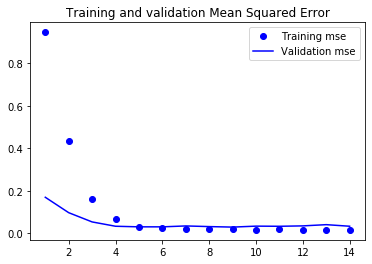

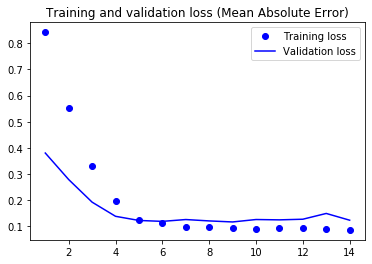

In [38]:
model_graph(CNN_fit, start=1)

In [51]:
CNN = load_model('./CNN/CNN40.h5')
# summarize model.
#mlp_predict.summary()

In [52]:
CNN_slope_per_pt = compare_slope_per_pt(CNN, 'image', image_type = 'masked', patient_IDs=test_ID, n_images=40)

In [53]:
slope_scores(CNN_slope_per_pt)


Number of predicted in Slopes Within 95% CI of Least Squares Estimate
24 correct 54.5 %


In [54]:
CNN_slope_per_pt

,Patient,Calculated_Slope,Lower_CI,Upper_CI,Predicted_Slope,Within_Range
0,ID00048637202185016727717,-1.190408,-2.901435,0.520618,-3.454768,No
1,ID00110637202210673668310,-28.182575,-43.359629,-13.005520,-3.454768,No
2,ID00339637202287377736231,-9.381848,-12.127840,-6.635855,-3.454768,No
3,ID00076637202199015035026,11.225948,5.072330,17.379566,-3.454768,No
4,ID00140637202231728595149,-1.510683,-6.126687,3.105322,-3.454768,Yes
5,ID00038637202182690843176,-0.800797,-4.409793,2.808199,-3.454768,Yes
6,ID00288637202279148973731,9.052208,-0.731771,18.836188,-3.454768,No
7,ID00421637202311550012437,-1.554030,-3.955740,0.847681,-3.454768,Yes
8,ID00251637202267455595113,-5.585897,-9.279468,-1.892325,-3.454768,Yes
9,ID00340637202287399835821,-3.814048,-7.682854,0.054758,-2.271594,Yes


### Best Run - CNN with Unmasked Images

In [68]:
now = datetime.datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
now


# CNN Training - Tuning
'./train.csv'
EPOCHS = 40
BATCH_SIZE = 24
CNN = create_cnn_new(regress=True)
callback = EarlyStopping(monitor='val_loss', patience=5)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'./CNN/CNN{now}.h5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)

opt = Adam(lr=0.0002)
CNN.compile(loss='mae',
              optimizer=opt,
              metrics=['mse'])

CNN.summary()

CNN_history = []

epochs=EPOCHS
CNN_fit = CNN.fit(image_data(keys=train_ID, 
                               a = target, 
                               tab = TAB), 
                    steps_per_epoch = 500,
                    validation_data=image_data(keys=test_ID, 
                               a = target, 
                               tab = TAB),
                    validation_steps = 250, 
                    callbacks = [callback, rlp, cpt], 
                    epochs=EPOCHS)

CNN_history.append(CNN_fit.history)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 512, 512, 16)      160       
_________________________________________________________________
activation_30 (Activation)   (None, 512, 512, 16)      0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 512, 512, 16)      64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
activation_31 (Activation)   (None, 256, 256, 32)    

In [69]:
CNN = load_model('./CNN/CNN2020-12-08-06:24:43.h5')
# summarize model.
#mlp_predict.summary()

In [70]:
CNN_slope_per_pt = compare_slope_per_pt(CNN, 'image', image_type = 'unmasked', patient_IDs=test_ID, n_images=40)
slope_scores(CNN_slope_per_pt)


Number of predicted in Slopes Within 95% CI of Least Squares Estimate
32 correct 72.7 %


In [71]:
CNN_slope_per_pt

,Patient,Calculated_Slope,Lower_CI,Upper_CI,Predicted_Slope,Within_Range
0,ID00048637202185016727717,-1.190408,-2.901435,0.520618,-5.141678,No
1,ID00110637202210673668310,-28.182575,-43.359629,-13.005520,-5.483864,No
2,ID00339637202287377736231,-9.381848,-12.127840,-6.635855,-9.030056,Yes
3,ID00076637202199015035026,11.225948,5.072330,17.379566,-4.627466,No
4,ID00140637202231728595149,-1.510683,-6.126687,3.105322,-2.807835,Yes
5,ID00038637202182690843176,-0.800797,-4.409793,2.808199,-2.786826,Yes
6,ID00288637202279148973731,9.052208,-0.731771,18.836188,-3.856339,No
7,ID00421637202311550012437,-1.554030,-3.955740,0.847681,-2.987168,Yes
8,ID00251637202267455595113,-5.585897,-9.279468,-1.892325,-4.129120,Yes
9,ID00340637202287399835821,-3.814048,-7.682854,0.054758,-5.370728,Yes


In [72]:
graph = predictions_for_graph(CNN, 'image', image_type = 'unmasked', n_images=40)

In [54]:
graph

,Patient,Weeks,FVC,FVC_prediction,FVC_calculated
0,ID00023637202179104603099,3,1368,1522.183399,1528.352545
1,ID00023637202179104603099,5,1361,1512.972332,1523.254241
2,ID00023637202179104603099,7,1465,1503.761265,1518.155938
3,ID00023637202179104603099,9,1681,1494.550198,1513.057634
4,ID00023637202179104603099,15,1461,1466.916996,1497.762723
...,...,...,...,...,...
338,ID00421637202311550012437,29,2716,2597.427214,2693.933133
339,ID00421637202311550012437,41,2833,2538.845372,2675.284774
340,ID00421637202311550012437,54,2771,2475.381709,2655.082386
341,ID00421637202311550012437,70,2628,2397.272586,2630.217907


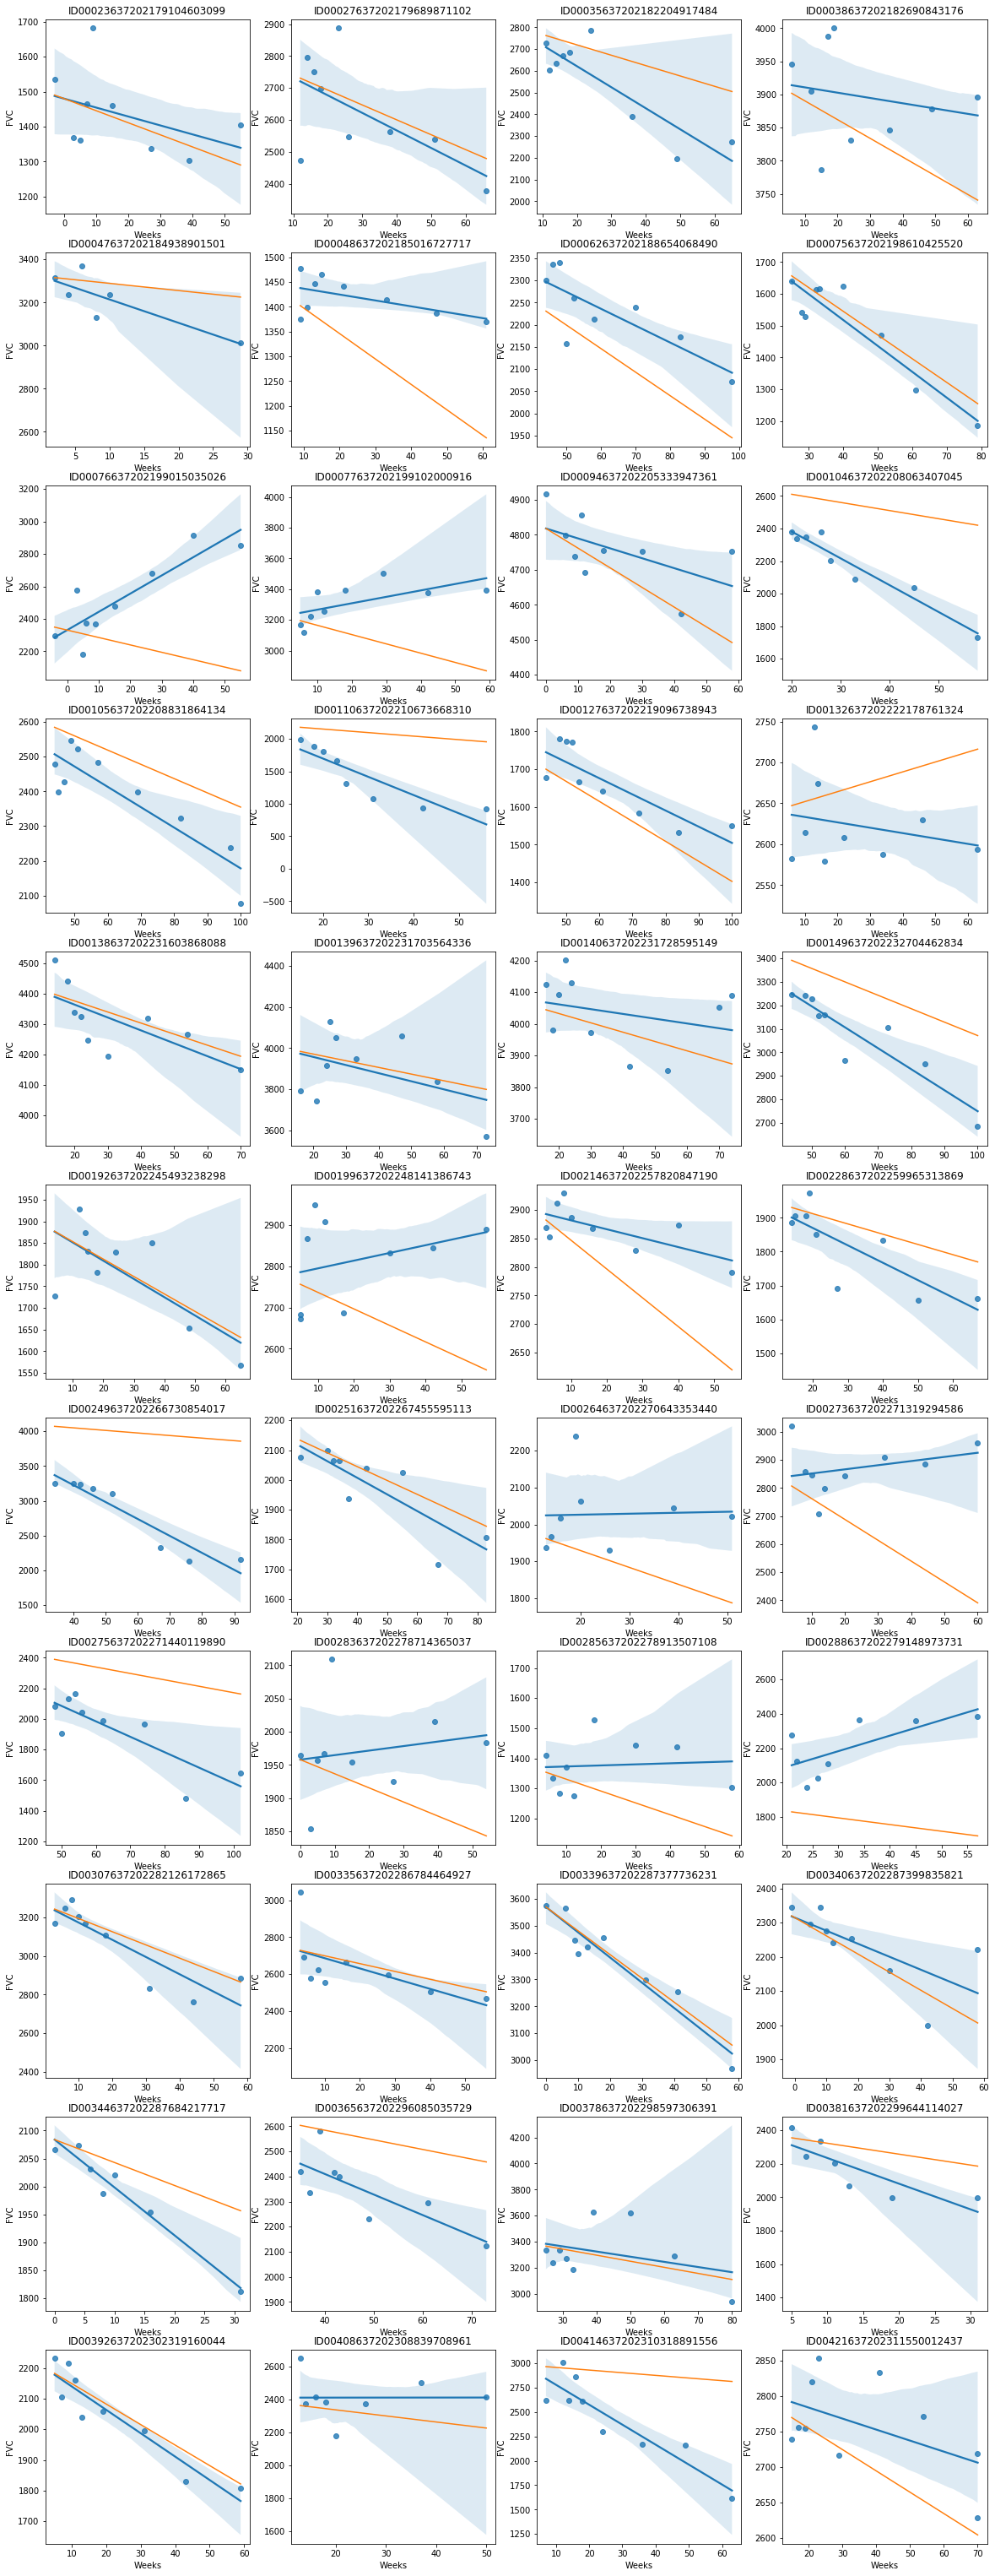

In [73]:
fvc_plot(graph)

## Regression with Tabular Data via Multi-Layer Perceptron

Model Building Function for Regression MLP

### Running MLP with Sequence

In [29]:
now = datetime.datetime.today().strftime('%Y-%m-%d-%H:%M:%S')


EPOCHS = 40
BATCH_SIZE = 24

mlp = create_mlp(6, regress=True)
callback = EarlyStopping(monitor='val_loss', patience=3)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'./MLP/MLP{now}.h5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto'
)

opt = Adam(lr=0.0002)

mlp.compile(loss='mae', optimizer=opt, metrics=['mse'])
mlp.summary()

mlp_history = []

print("[INFO] training model...")

# mlp_fit = mlp.fit(x=train_tab, y=train_target, 
#                   validation_data=(test_tab, test_target), epochs=40, batch_size=24, callbacks=[callback])

mlp_fit = mlp.fit(tab_data(keys=train_ID, 
                               a = target, 
                               tab = TAB), 
                    steps_per_epoch = 500,
                    validation_data=tab_data(keys=test_ID, 
                               a = target, 
                               tab = TAB),
                    validation_steps = 250, 
                    callbacks = [callback, cpt], 
                    epochs=EPOCHS)

mlp_history.append(mlp_fit.history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
[INFO] training model...
Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: 0.1235 - mse: 0.0270
Epoch 00001: val_loss improved from inf to 0.13026, saving model to ./MLP/MLP40.h5
500/500 [==============================] - 22s 43ms/step - loss: 0.1234 - mse: 0.0269 - val_loss: 0.1303 - val_mse: 0.0315
Epoch 2/40
499/500 [============================>.] - ETA: 0s - loss

In [30]:
MLP = load_model('./MLP/MLP40.h5')

In [31]:
mlp_slope_per_pt = compare_slope_per_pt(MLP, 'text', image_type = 'unmasked', patient_IDs=test_ID, n_images=40)
slope_scores(mlp_slope_per_pt)


Number of predicted in Slopes Within 95% CI of Least Squares Estimate
25 correct 56.8 %


## Combined Model

Run the combined model incoprorating multi-layer perceptron for tabular data and CNN for image data

In [75]:
now = datetime.datetime.today().strftime('%Y-%m-%d-%H:%M:%S')


EPOCHS = 40
BATCH_SIZE = 24

# def step_decay(epoch):
#    initial_lrate = 0.0001
#    drop = 0.5
#    epochs_drop = 3
#    lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#    return lrate

mlp = create_mlp(6, regress=False)
cnn = create_cnn_new(regress=False)

combinedInput = concatenate([cnn.output, mlp.output])

x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

Combined = Model(inputs=[cnn.input, mlp.input], outputs=x)

opt = Adam(lr=0.0002)

callback = EarlyStopping(monitor='val_loss', patience=10)

cpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'./combined/combined{now}.h5',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=SAVE_BEST,
    mode='auto')

Combined.compile(loss='mae', optimizer=opt, metrics=['mse'])

Combined.summary()

model_history = []

Combined_fit = Combined.fit(combined_data(keys=train_ID, 
                               a = target, 
                               tab = TAB), 
                    steps_per_epoch = 500,
                    validation_data=combined_data(keys=test_ID, 
                               a = target, 
                               tab = TAB),
                    validation_steps = 250, 
                    callbacks = [callback, cpt], 
                    epochs=EPOCHS)

model_history.append(Combined_fit.history)

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 512, 512, 16) 160         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 512, 512, 16) 0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 512, 512, 16) 64          activation_40[0][0]              
______________________________________________________________________________________

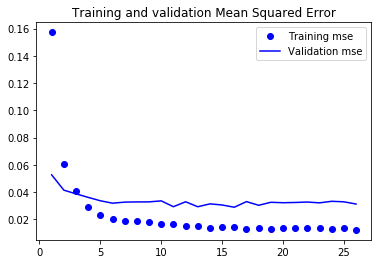

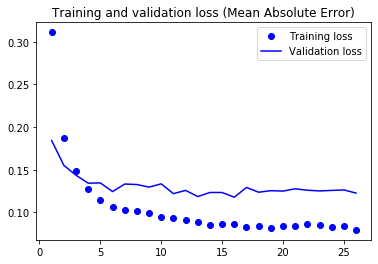

In [76]:
model_graph(Combined_fit, start=0)

In [37]:
Combined = load_model('./combined/combined2020-12-06-09:30:40.h5')

In [38]:
combined_slope_per_pt = compare_slope_per_pt(Combined, 'combined', image_type = 'unmasked', patient_IDs=test_ID, n_images=40)

In [39]:
slope_scores(combined_slope_per_pt)


Number of predicted in Slopes Within 95% CI of Least Squares Estimate
30 correct 68.2 %
